In [1]:
from mmpose.apis import init_pose_model

def get_pose_net(device='cuda:0'):
    backbone_config="/workspace/LT_HICT/mmpose/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py"
#     backbone_checkpoint='https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_384x288_dark-741844ba_20200812.pth'
    backbone_checkpoint='https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth'
    pose_model = init_pose_model(backbone_config, backbone_checkpoint)#, device=args.device.lower()
    pose_model.train()
    print('network model loaded.')

    return pose_model

/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [2]:
tmp_hrnet = get_pose_net()
tmp_hrnet.eval()
print('model changed to eval mode')

load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth
network model loaded.
model changed to eval mode


In [3]:
import torch
from torch.utils.data import DataLoader
from mvn.models.HICT_triangulation_384x288 import VolumetricTriangulationNet_384x288
from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.utils.img import get_square_bbox, resize_image, crop_image, normalize_image, scale_bbox
# IMAGENET_MEAN, IMAGENET_STD = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

import torchvision.transforms as transforms

from mvn.datasets import human36m_EXTENDED
from mvn.datasets import utils as dataset_utils
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
config = cfg.load_config('/workspace/LT_HICT/experiments/human36m/train/HICT_human36m_vol_384x288.yaml')

In [4]:
import yk_utils.vis_debug as vis_debug

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

In [5]:
device = 0
model = VolumetricTriangulationNet_384x288(config, device=device).to(device)

In [6]:
# data/current_best.pth is for, VolumetricTriangulationNet_Wholebody_512x512.
# model_checkpoint = '/workspace/LT_HICT/data/current_best.pth'
model_checkpoint = '/workspace/LT_HICT/data/384_288_epoch38.pth'
state_dict = torch.load(model_checkpoint)
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [7]:
config.dataset.train.pred_results_path = '/workspace/LT_HICT/data/eval_donotshuffle_train_result.pkl'
config.dataset.val.pred_results_path = '/workspace/LT_HICT/data/eval_donotshuffle_eval_result.pkl'

# config.dataset.train.pred_results_path = '/workspace/learnable_triangulation/logs/eval_HICT_human36m_alg_DONOTSHUFFLE_WITHDAMAGE_AlgebraicTriangulationNet_384x288_TRAIN/checkpoints/0000/results.pkl'
# config.dataset.val.pred_results_path = '/workspace/learnable_triangulation/logs/eval_HICT_human36m_alg_DONOTSHUFFLE_WITHDAMAGE_AlgebraicTriangulationNet_384x288_new_EVAL/checkpoints/0000/results.pkl'

In [8]:
# loda evaluation dataset
is_train = False
is_train = True
if is_train:
    pred_result_pth = config.dataset.train.pred_results_path
else:
    pred_result_pth = config.dataset.val.pred_results_path

batch_size = 1
shuffle_data = False

HUMAN36M_dataset = human36m_EXTENDED.Human36MMultiViewDataset_EXTENDED(h36m_root='/datasets/human36m/images',
            labels_path="/datasets/human36m/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy",
            pred_results_path=pred_result_pth,
            image_shape=(384, 288),
            train=is_train,
            test=not is_train,
            retain_every_n_frames_in_test=1,
            with_damaged_actions=True,
            cuboid_side=2000.0,
            scale_bbox=1.2,
            norm_image=True,
            kind="mpii",
            undistort_images=False,
            ignore_cameras=[],
            crop=True,
            option_384x288=True)


HUMAN36M_dataloader = DataLoader(
    HUMAN36M_dataset,
    batch_size=batch_size,
    shuffle=shuffle_data,
    collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                                min_n_views=4,
                                                max_n_views=4),
    num_workers=8,
    worker_init_fn=dataset_utils.worker_init_fn,
    pin_memory=True
)

iterator = enumerate(HUMAN36M_dataloader)

print(HUMAN36M_dataset.__len__())

159181


In [9]:
with torch.no_grad():
    for iter_i, batch in iterator:
        # with autograd.detect_anomaly():
        images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, \
        keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)

        # get model output
        # forward(self, images, proj_matricies, batch)
        # return : vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points
        vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points = model(images_batch, batch)

        break

In [10]:
# images_batch.shape # torch.Size([1, 4, 3, 384, 288])
# keypoints_3d_gt.shape # torch.Size([1, 16, 3])
# keypoints_3d_validity_gt.shape # torch.Size([1, 16, 1])
# proj_matricies_batch.shape # torch.Size([1, 4, 3, 4])
# keypoints_3d_extended_gt.shape # torch.Size([1, 25, 3])

In [11]:
for key in batch.keys():
    print(key)

images
original_image
detections
cameras
original_cameras
keypoints_3d
indexes
subject
action
keypoints_3d_extended
pred_keypoints_3d
image_path


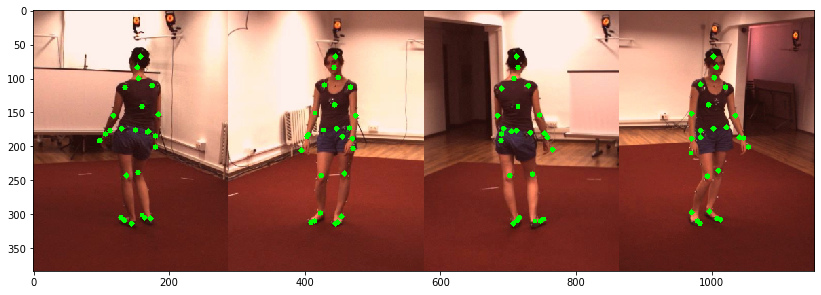

In [12]:
# v_concated_image = vis_debug.visualize_batch_input(images_batch)
concated = vis_debug.make_concated_output(batch, keypoints_3d_extended_gt, joint_color=(0, 255, 0))
plt.figure(figsize=(14, 11))
plt.imshow(concated[:,:,::-1])

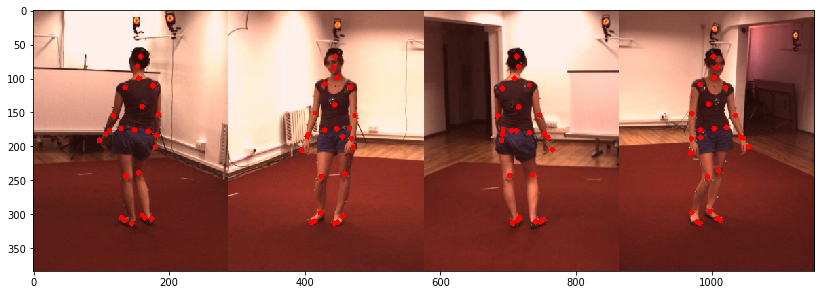

In [13]:
# v_concated_image = vis_debug.visualize_batch_input(images_batch)
concated = vis_debug.make_concated_output(batch, vol_keypoints_3d, joint_color=(0, 0, 255))
plt.figure(figsize=(14, 11))
plt.imshow(concated[:,:,::-1])

In [14]:
with torch.no_grad():
    for iter_i, batch in iterator:
        # with autograd.detect_anomaly():
        images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, \
        keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)

        # get model output
        # forward(self, images, proj_matricies, batch)
        # return : vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points
        vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points = model(images_batch, batch)

        break

In [15]:
images_batch.shape

torch.Size([1, 4, 3, 384, 288])

In [16]:
for key in batch.keys():
    print(key)

# only pred_keypoints_3d, cameras are used.

images
original_image
detections
cameras
original_cameras
keypoints_3d
indexes
subject
action
keypoints_3d_extended
pred_keypoints_3d
image_path


In [17]:
with torch.no_grad():
    for iter_i, batch in iterator:
        # with autograd.detect_anomaly():
        images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, \
        keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)

        # del batch['images']
        del batch['original_image']
        del batch['detections']
        del batch['original_cameras']
        del batch['keypoints_3d']
        del batch['indexes']
        del batch['subject']
        del batch['action']
        del batch['keypoints_3d_extended']
        del batch['image_path']

        # get model output
        # forward(self, images, proj_matricies, batch)
        # return : vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points
        vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points = model(images_batch, batch)

        break

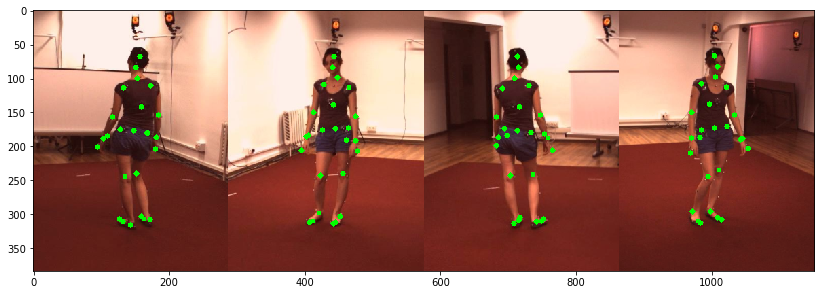

In [18]:
# v_concated_image = vis_debug.visualize_batch_input(images_batch)
concated = vis_debug.make_concated_output(batch, keypoints_3d_extended_gt, joint_color=(0, 255, 0))
plt.figure(figsize=(14, 11))
plt.imshow(concated[:,:,::-1])

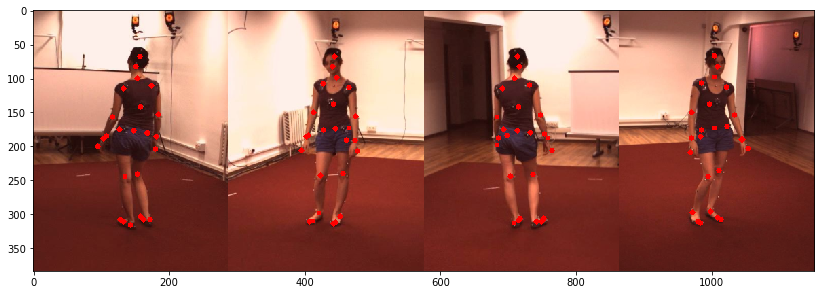

In [19]:
# v_concated_image = vis_debug.visualize_batch_input(images_batch)
concated = vis_debug.make_concated_output(batch, vol_keypoints_3d, joint_color=(0, 0, 255))
plt.figure(figsize=(14, 11))
plt.imshow(concated[:,:,::-1])

# LOAD CAMERA EXTRINSICS

In [20]:
RT_cam_0 = np.array([[-8.34142923e-01,  5.51274657e-01, -1.73759162e-02, -1.48328590e+00],
                    [ 1.46136150e-01,  1.90523684e-01, -9.70744550e-01,  8.99315166e+00],
                    [-5.31836331e-01, -8.12278926e-01, -2.39485085e-01,  2.64958496e+01]]).astype(np.float32)

RT_cam_1 = np.array([[-0.8233248,  -0.56654638, -0.03408067, -3.58436418],
                    [-0.11005677,  0.2182685 , -0.96966302,  7.6899395 ],
                    [ 0.5567978 , -0.79459679 ,-0.24205816 ,30.61686516]]).astype(np.float32)

RT_cam_2 = np.array([[ 7.32802153e-01, -6.80310309e-01 ,-1.33749619e-02 , 2.68236399e+00],
                    [-1.93192452e-01, -1.89171150e-01, -9.62751746e-01,  7.18710995e+00],
                    [ 6.52439773e-01 , 7.08090544e-01 ,-2.70055830e-01 , 2.72664452e+01]]).astype(np.float32)

RT_cam_3 = np.array([[ 0.7552433,   0.65489656 , 0.02679667 , 4.26243305],
                    [ 0.21350731, -0.20715716, -0.95472538,  7.85799599],
                    [-0.61969525,  0.72677124, -0.29627925 ,24.44694138]]).astype(np.float32)

In [21]:
K_cam_0_npz = np.load('/workspace/goPro_debug/exp_03/cam_00_intrinsic_result.npz')
K_cam_0 = K_cam_0_npz['mtx'].astype(np.float32)
K_cam_1_npz = np.load('/workspace/goPro_debug/exp_03/cam_01_intrinsic_result.npz')
K_cam_1 = K_cam_1_npz['mtx'].astype(np.float32)
K_cam_2_npz = np.load('/workspace/goPro_debug/exp_03/cam_02_intrinsic_result.npz')
K_cam_2 = K_cam_2_npz['mtx'].astype(np.float32)
K_cam_3_npz = np.load('/workspace/goPro_debug/exp_03/cam_03_intrinsic_result.npz')
K_cam_3 = K_cam_3_npz['mtx'].astype(np.float32)

In [22]:
# synthesis camera
from mvn.utils.multiview import Camera

scale_correction = 100.
# def __init__(self, R, t, K, dist=None, name=""):
camera_maden_00 = Camera(RT_cam_0[:3,:3], RT_cam_0[:3,3], K_cam_0, name="camera_00")
camera_maden_01 = Camera(RT_cam_1[:3,:3], RT_cam_1[:3,3], K_cam_1, name="camera_01")
camera_maden_02 = Camera(RT_cam_2[:3,:3], RT_cam_2[:3,3], K_cam_2, name="camera_02")
camera_maden_03 = Camera(RT_cam_3[:3,:3], RT_cam_3[:3,3], K_cam_3, name="camera_03")

# SYNTHESIS BATCH INPUT

In [23]:
img_cam_00 = cv2.imread('/workspace/goPro_debug/exp_03/cam_00/motion_images/0001.jpg')
bbox_00 = np.array([200, 1100, 2000, 2900], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

img_cam_01 = cv2.imread('/workspace/goPro_debug/exp_03/cam_01/motion_images/0001.jpg')
bbox_01 = np.array([200, 900, 2000, 2700], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

img_cam_02 = cv2.imread('/workspace/goPro_debug/exp_03/cam_02/motion_images/0001.jpg')
bbox_02 = np.array([100, 1000, 1900, 2800], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

img_cam_03 = cv2.imread('/workspace/goPro_debug/exp_03/cam_03/motion_images/0001.jpg')
bbox_03 = np.array([50, 1100, 1850, 2900], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]
# bbox is top left and bottom right

In [24]:
def make_image_camera(_img, _camera, _bbox):
    _img_synth = copy.deepcopy(_img)
    _camera_synth = copy.deepcopy(_camera)
    _bbox_synth = copy.deepcopy(_bbox[[1,0,3,2]]) # TLBR to LTRB

    # crop image and update camera
    _img_synth = crop_image(_img_synth, _bbox_synth)
    _camera_synth.update_after_crop(_bbox_synth)

    # resize image and update camera
    image_shape_before_resize = _img_synth.shape[:2] # (2160, 3840)
    _img_synth = resize_image(_img_synth, (384, 288))
    _camera_synth.update_after_resize(image_shape_before_resize, (384, 288))

    _img_synth = transform(_img_synth) # torch.Size([3, 2160, 3840])

    return _img_synth, _camera_synth


In [25]:
# TLBR to LTRB....
# bbox = shot['bbox_by_camera_tlbr'][camera_idx][[1,0,3,2]] # TLBR to LTRB

In [26]:
from mvn.models.HICT_triangulation_384x288 import AlgebraicTriangulationNet_384x288

In [27]:
config = cfg.load_config('/workspace/LT_HICT/experiments/human36m/train/HICT_human36m_alg_384x288.yaml')

In [28]:
device = 0
model = AlgebraicTriangulationNet_384x288(config, device=device).to(device)

In [29]:
model_checkpoint = '/workspace/LT_HICT/data/384_288_alg_epoch19.pth'
state_dict = torch.load(model_checkpoint)
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [30]:
iter_i

2

In [34]:
img_count = 0

with torch.no_grad():
    for iter_i, batch in iterator:
        # with autograd.detect_anomaly():
        # images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, \
        # keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)

        # get model output
        # forward(self, images, proj_matricies, batch)
        # return : vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points
        # vol_keypoints_3d, features, volumes, vol_confidences, cuboids, coord_volumes, base_points = model(images_batch, batch)

        # alg model
        device = 0
        batch_synth = copy.deepcopy(batch)

        img_cam_00 = cv2.imread('/workspace/goPro_debug/exp_03/cam_00/motion_images/%04d.jpg'%iter_i)
        bbox_00 = np.array([200, 1100, 2000, 2900], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

        img_cam_01 = cv2.imread('/workspace/goPro_debug/exp_03/cam_01/motion_images/%04d.jpg'%iter_i)
        bbox_01 = np.array([200, 900, 2000, 2700], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

        img_cam_02 = cv2.imread('/workspace/goPro_debug/exp_03/cam_02/motion_images/%04d.jpg'%iter_i)
        bbox_02 = np.array([100, 1000, 1900, 2800], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]

        img_cam_03 = cv2.imread('/workspace/goPro_debug/exp_03/cam_03/motion_images/%04d.jpg'%iter_i)
        bbox_03 = np.array([50, 1100, 1850, 2900], dtype=int) #shot['bbox_by_camera_tlbr'][camera_idx]
        # bbox is top left and bottom right

        img_cam_00_synth, retval_camera_00_synth = make_image_camera(img_cam_00, camera_maden_00, bbox_00)
        img_cam_01_synth, retval_camera_01_synth = make_image_camera(img_cam_01, camera_maden_01, bbox_01)
        img_cam_02_synth, retval_camera_02_synth = make_image_camera(img_cam_02, camera_maden_02, bbox_02)
        img_cam_03_synth, retval_camera_03_synth = make_image_camera(img_cam_03, camera_maden_03, bbox_03)

        batch_synth['cameras'][0][0] = copy.deepcopy(retval_camera_00_synth)
        batch_synth['cameras'][1][0] = copy.deepcopy(retval_camera_01_synth)
        batch_synth['cameras'][2][0] = copy.deepcopy(retval_camera_02_synth)
        batch_synth['cameras'][3][0] = copy.deepcopy(retval_camera_03_synth)

        batch_synth['pred_keypoints_3d'].shape
        batch_synth['pred_keypoints_3d'][0][6] = np.array([0., 0., 903.26135], dtype=np.float32)

        images_batch_synth = torch.zeros(1, 4, 3, 384, 288).to(device)
        images_batch_synth[0,0,:,:,:] = img_cam_00_synth
        images_batch_synth[0,1,:,:,:] = img_cam_01_synth
        images_batch_synth[0,2,:,:,:] = img_cam_02_synth
        images_batch_synth[0,3,:,:,:] = img_cam_03_synth

        new_cameras = copy.deepcopy(batch_synth['cameras'])
        proj_matricies = torch.stack([torch.stack([torch.from_numpy(camera.projection) for camera in camera_batch], dim=0) for camera_batch in new_cameras], dim=0).transpose(1, 0)  # shape (batch_size, n_views, 3, 4)
        proj_matricies_batch_synth = proj_matricies.float().to(device)
        
        keypoints_3d_pred, keypoints_2d_pred, heatmaps_pred, confidences_pred = model(images_batch_synth, proj_matricies_batch_synth, None)
        # keypoints_3d_pred.shape : torch.Size([1, 25, 3]) < EXTENDED ALG MODEL...!
        concated = make_concated_output(images_batch_synth, keypoints_3d_pred, proj_matricies_batch_synth)

        cv2.imwrite('/workspace/goPro_debug/exp_03/output_debug/%04d.jpg'%img_count, concated)
        img_count += 1
        
        if iter_i == 93:
            break

        # break

In [32]:
def make_output(images_synth, idx_cam, keypoints_3D, proj_matricies_batch_synth, joint_color = (0, 0, 255)):
    batch_image_cam = images_synth[0, idx_cam, :, :, :].detach().cpu().numpy()
    batch_image_cam = batch_image_cam.transpose(1, 2, 0)
    batch_image_cam = cv2.normalize(batch_image_cam, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    P = proj_matricies_batch_synth[0,idx_cam].detach().cpu().numpy()
    #D2_keypoints = keypoints_2d.detach().cpu().numpy().astype(np.float64)[0] # (view, joint, xy)
    D3_keypoints = keypoints_3D.detach().cpu().numpy().astype(np.float64)[0]
    num_joint = keypoints_3D.shape[1]
    D3_keypoints = cv2.hconcat([D3_keypoints, np.ones((num_joint,1))]) # for # [17,4] homogenious

    for joint in range(num_joint):
        one_point = D3_keypoints[joint,:4]

        projected = np.matmul(P, one_point)
        projected = projected/projected[-1]
        batch_image_cam = cv2.circle(batch_image_cam, (int(projected[0]),int(projected[1])), 0, joint_color, 7)
        #batch_image_cam = cv2.circle(batch_image_cam, (int(D2_keypoints[idx_cam,joint,0]),int(D2_keypoints[idx_cam,joint,1])), 0, [255, 0, 0], 10)


    return batch_image_cam

In [33]:
def make_concated_output(images_synth, keypoints_3d_extended_gt, proj_matricies_batch_synth, joint_color = (0, 0, 255)):
    batch_image_cam0 = make_output(images_synth, 0, keypoints_3d_extended_gt, proj_matricies_batch_synth, joint_color)
    batch_image_cam1 = make_output(images_synth, 1, keypoints_3d_extended_gt, proj_matricies_batch_synth, joint_color)
    batch_image_cam2 = make_output(images_synth, 2, keypoints_3d_extended_gt, proj_matricies_batch_synth, joint_color)
    batch_image_cam3 = make_output(images_synth, 3, keypoints_3d_extended_gt, proj_matricies_batch_synth, joint_color)

    concated = cv2.hconcat([batch_image_cam0, batch_image_cam1,\
                            batch_image_cam2, batch_image_cam3])

    return concated   

In [ ]:
concated = make_concated_output(images_batch_synth, keypoints_3d_pred, proj_matricies_batch_synth)

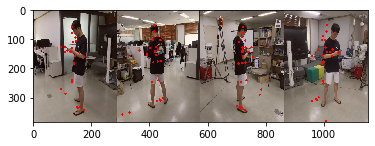

In [ ]:
plt.imshow(concated[:,:,::-1])

In [ ]:
proj_matricies_batch_synth.shape

torch.Size([1, 4, 3, 4])

In [ ]:
batch['images'] = images_batch_synth.detach().cpu().numpy()

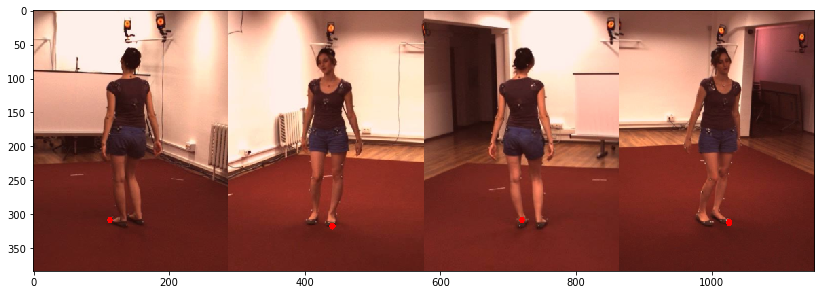

In [ ]:
# v_concated_image = vis_debug.visualize_batch_input(images_batch)
concated = vis_debug.make_concated_output(batch, keypoints_3d_pred, joint_color=(0, 0, 255))
plt.figure(figsize=(14, 11))
plt.imshow(concated[:,:,::-1])

In [ ]:
# images_batch.shape # torch.Size([1, 4, 3, 384, 288])

torch.Size([1, 4, 3, 384, 288])

# DEBUG CAMERA EXTRINSICS

In [ ]:
from scipy.spatial.transform import Rotation as scipy_R

In [ ]:
def calculate_Tr(rvec_np, tvec_np):
    _R_cv2bcam = np.array([[1,0,0],
                       [0,-1,0],
                       [0,0,-1]])
    R, _ = cv2.Rodrigues(rvec_np)
    # t = tvec_np[_i]/100. #(mm to M)? scale problem exist.
    t = tvec_np #(mm to M)? scale problem exist.
    R_bcam= np.matmul(_R_cv2bcam, R)
    T_bcam = np.matmul(_R_cv2bcam, t)                       
    R_world = R_bcam.transpose()
    T_world = -np.matmul(R_world, T_bcam)

    R_world = R_world.reshape(3,3)
    T_world = T_world.reshape(3,1)

    Tr = np.identity(4)
    Tr[:3,:3] = R_world
    Tr[:3,3:] = T_world

    return Tr

In [ ]:
cam_0 = copy.deepcopy(batch['cameras'][0][0])
cam_1 = copy.deepcopy(batch['cameras'][1][0])
cam_2 = copy.deepcopy(batch['cameras'][2][0])
cam_3 = copy.deepcopy(batch['cameras'][3][0])

global_t_scale = 0.01

# R_cam_2 = cam_2.projection[:3, :3]
# t_cam_2 = cam_2.projection[:3, 3]
R_cam_0 = cam_0.R
t_cam_0 = cam_0.t
cam_0_rvec = scipy_R.from_matrix(R_cam_0).as_rotvec()
cam_0_tvec = t_cam_0
cam_0_tvec *= global_t_scale
cam_0_Tr = calculate_Tr(cam_0_rvec, cam_0_tvec)

R_cam_1 = cam_1.R
t_cam_1 = cam_1.t
cam_1_rvec = scipy_R.from_matrix(R_cam_1).as_rotvec()
cam_1_tvec = t_cam_1
cam_1_tvec *= global_t_scale
cam_1_Tr = calculate_Tr(cam_1_rvec, cam_1_tvec)

R_cam_2 = cam_2.R
t_cam_2 = cam_2.t
cam_2_rvec = scipy_R.from_matrix(R_cam_2).as_rotvec()
cam_2_tvec = t_cam_2
cam_2_tvec *= global_t_scale
cam_2_Tr = calculate_Tr(cam_2_rvec, cam_2_tvec)

R_cam_3 = cam_3.R
t_cam_3 = cam_3.t
cam_3_rvec = scipy_R.from_matrix(R_cam_3).as_rotvec()
cam_3_tvec = t_cam_3
cam_3_tvec *= global_t_scale
cam_3_Tr = calculate_Tr(cam_3_rvec, cam_3_tvec)


In [ ]:
# # /workspace/LT_HICT/data/cam_00_Tr.npy
# np.save('/workspace/LT_HICT/data/cam_00_Tr.npy', cam_0_Tr)
# np.save('/workspace/LT_HICT/data/cam_01_Tr.npy', cam_1_Tr)
# np.save('/workspace/LT_HICT/data/cam_02_Tr.npy', cam_2_Tr)
# np.save('/workspace/LT_HICT/data/cam_03_Tr.npy', cam_3_Tr)

In [ ]:
RT_cam_0 = np.array([[-8.34142923e-01,  5.51274657e-01, -1.73759162e-02, -1.48328590e+00],
                    [ 1.46136150e-01,  1.90523684e-01, -9.70744550e-01,  8.99315166e+00],
                    [-5.31836331e-01, -8.12278926e-01, -2.39485085e-01,  2.64958496e+01]])

RT_cam_1 = np.array([[-0.8233248,  -0.56654638, -0.03408067, -3.58436418],
                    [-0.11005677,  0.2182685 , -0.96966302,  7.6899395 ],
                    [ 0.5567978 , -0.79459679 ,-0.24205816 ,30.61686516]])

RT_cam_2 = np.array([[ 7.32802153e-01, -6.80310309e-01 ,-1.33749619e-02 , 2.68236399e+00],
                    [-1.93192452e-01, -1.89171150e-01, -9.62751746e-01,  7.18710995e+00],
                    [ 6.52439773e-01 , 7.08090544e-01 ,-2.70055830e-01 , 2.72664452e+01]])

RT_cam_3 = np.array([[ 0.7552433,   0.65489656 , 0.02679667 , 4.26243305],
                    [ 0.21350731, -0.20715716, -0.95472538,  7.85799599],
                    [-0.61969525,  0.72677124, -0.29627925 ,24.44694138]])

In [ ]:
scale_correction = 100.

# R_cam_2 = cam_2.projection[:3, :3]
# t_cam_2 = cam_2.projection[:3, 3]
R_cam_0 = RT_cam_0[:3, :3]
t_cam_0 = RT_cam_0[:3, 3]
cam_0_rvec = scipy_R.from_matrix(R_cam_0).as_rotvec()
cam_0_tvec = t_cam_0
cam_0_tvec *= global_t_scale * scale_correction
cam_0_Tr = calculate_Tr(cam_0_rvec, cam_0_tvec)

R_cam_1 = RT_cam_1[:3, :3]
t_cam_1 = RT_cam_1[:3, 3]
cam_1_rvec = scipy_R.from_matrix(R_cam_1).as_rotvec()
cam_1_tvec = t_cam_1
cam_1_tvec *= global_t_scale * scale_correction
cam_1_Tr = calculate_Tr(cam_1_rvec, cam_1_tvec)

R_cam_2 = RT_cam_2[:3, :3]
t_cam_2 = RT_cam_2[:3, 3]
cam_2_rvec = scipy_R.from_matrix(R_cam_2).as_rotvec()
cam_2_tvec = t_cam_2
cam_2_tvec *= global_t_scale * scale_correction
cam_2_Tr = calculate_Tr(cam_2_rvec, cam_2_tvec)

R_cam_3 = RT_cam_3[:3, :3]
t_cam_3 = RT_cam_3[:3, 3]
cam_3_rvec = scipy_R.from_matrix(R_cam_3).as_rotvec()
cam_3_tvec = t_cam_3
cam_3_tvec *= global_t_scale * scale_correction
cam_3_Tr = calculate_Tr(cam_3_rvec, cam_3_tvec)

In [ ]:
# # /workspace/LT_HICT/data/cam_00_Tr.npy
# np.save('/workspace/goPro_debug/exp_03/cam_00_Tr_debug.npy', cam_0_Tr)
# np.save('/workspace/goPro_debug/exp_03/cam_01_Tr_debug.npy', cam_1_Tr)
# np.save('/workspace/goPro_debug/exp_03/cam_02_Tr_debug.npy', cam_2_Tr)
# np.save('/workspace/goPro_debug/exp_03/cam_03_Tr_debug.npy', cam_3_Tr)